# $E_{peak} - E_{iso}$ correlation

The correlation between $E_\text{peak}$ (spectral peak energy from the $\nu F_\nu \text{ vs. } \nu$ diagram) and $E_\text{iso}$ (equivalent isotropic energy, which derives from the flux multiplied by time and distance: $E_\text{iso} = 4\pi D_L^2Ft/(1+z) = 4\pi D_L^2S/(1+z)$, where the fluence is $S=\int Fdt$) is one of the relations proposed to have an application for cosmology, i.e. for constraining cosmological parameters, since the luminosity distance needed to compute $E_\text{iso}$ depends on a specific cosmology $D_L(z; H_0, \Omega)$. Therefore, the values for the free parameters of this fit will change for different cosmologies, since this has an effect the x-axis position of the scatter. However, we will explore this effect and try to constrain cosmological parameters later in [Epeak_Eiso_cosmology.ipynb](https://github.com/joanalnu/OAB-INAF/blob/main/Epeak_Eiso_cosmology.ipynb).

To work with $E_\text{peak}$ and $E_\text{iso}$ we will use logarithmic scaling, that means that we'll simplify the mathematical complexity by taking the logarithm on the data and the power-law model.
$$
\begin{align*}
    E_\text{peak} &= A \cdot E_\text{iso}^m \\
    \log_{10} (E_\text{peak}) &= \log_{10}(A) + \log_{10} (E_\text{iso}) \times m \\
    y &= k + mx
\end{align*}
$$

In [2]:
from http.cookiejar import MISSING_FILENAME_TEXT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('table.csv') # read the data from Ghirlanda et al. 2008

Pandas reads the `'Eiso'` and `'Eiso_err'` columns as `string`, so passing the lists through `get_float()` returns the correct variable type.

In [4]:
def get_float(col):
    return np.array([float(base) * 10**float(exponent) for val in col for base, exponent in [str(val).split('e')]])

Let's plot the data to see its distribution.

Text(0, 0.5, '$log(E_{\\text{peak}})$')

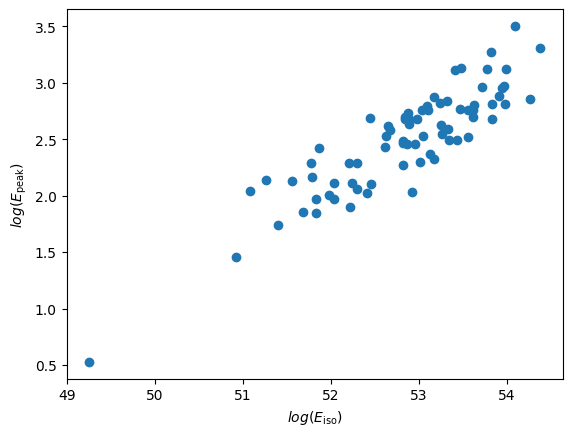

In [5]:
Epeak = np.log10(df['Epeak']) # keV
Eiso = np.log10(get_float(df['Eiso'])) # ergs

plt.figure()
plt.scatter(Eiso, Epeak)

plt.xlabel(r'$log(E_{\text{iso}})$')
plt.ylabel(r'$log(E_{\text{peak}})$')

To find the best fit for these GRB properties with the model previously defined, I will use a goodness of fit (`GoF`) function using the $\chi^2$ statistical test following:
$$\chi^2 = \sum_i (O_i - E_i)^2$$,
where $O_i$ and $E_i$ are the obsered and expected values respectively. By defining a parameter space (k,m) and computing the $\chi^2$ value for each combination of parameters, the best combination will be that with lowest $\chi^2$ (i.e. 'least squares' method).

In [6]:
def GoF(m,k, x=Eiso, y=Epeak):
    """
    Goodness of fit following the chi-squared formula
    :param m: slope
    :param k: y-axis cut
    :param x: x-values
    :param y: y-values
    :return: chi-squared value
    """
    model = m*x + k
    chi_squared = np.sum((y-model)**2)
    return chi_squared

In [7]:
# Define parameter ranges
k = np.linspace(-25.,-20.,100) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,100) # the slope must be positive

G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
for i in range(len(m)):
    for j in range(len(k)):
        G[i,j] = GoF(m[i], k[j], x=Eiso, y=Epeak)

0.4545454545454546 -21.515151515151516


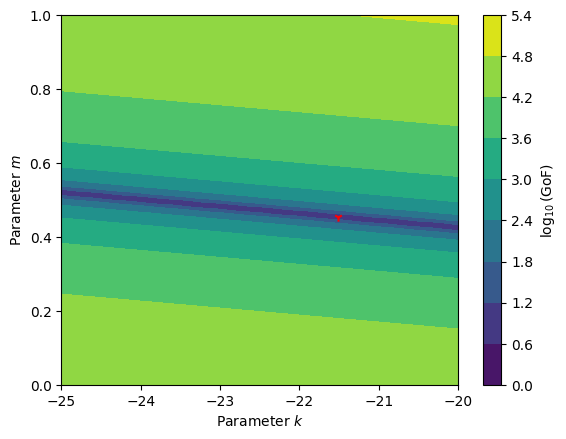

In [8]:
# extract best fit parameters
best_fit = np.argmin(G)
m_index, k_index = np.unravel_index(best_fit, G.shape)
m_fit, k_fit = m[m_index], k[k_index]
print(m_fit, k_fit)

plt.figure()
plt.contourf(k, m, np.log10(G))#, levels=50)
plt.colorbar(label=r'$\log_{10} (\text{GoF})$')
plt.xlabel(r'Parameter $k$')
plt.ylabel(r'Parameter $m$')
plt.scatter(k_fit, m_fit, marker='1', color='r')

In the last cells, we've used the `GoF` function to compute the best fit parameters of a predefined parameter space. Now, let's visualize the best fit results superposed with the data.

Text(0, 0.5, '$E_\\text{peak}$')

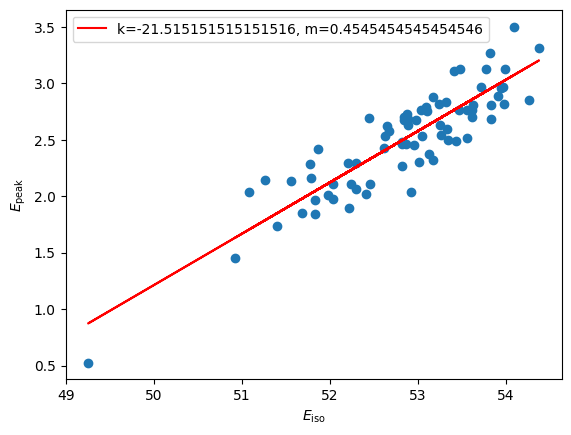

In [9]:
plt.figure()
plt.scatter(Eiso, Epeak)
plt.plot(Eiso, k_fit+Eiso*m_fit, label=f'k={k_fit}, m={m_fit}', color='r')
# plt.plot(Eiso, -24+Eiso*0.5, color='g', label=f'k={-24}, m={0.5}') # line used to calibrate the parameter space
plt.legend()
plt.xlabel(r'$E_\text{iso}$')
plt.ylabel(r'$E_\text{peak}$')

In [17]:
def measure_distances(a, b, x, y):
    """
    Measures the distance between a point p = (x,y) and a line of best fit y=ax+b.
    :param p: coordinates of the point
    :param a: slope of the fit
    :param b: y-axis cut of the fit
    :return: scalar for the distance
    """
    # for the line point we use x0=0 and thus y0=b
    numerator = abs(a*x -y +b)
    denominator = np.sqrt(1 + (a ** 2))
    return numerator / denominator

def gaussian(x, mu, sigma):
    return (1/sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2)) # gaussian function

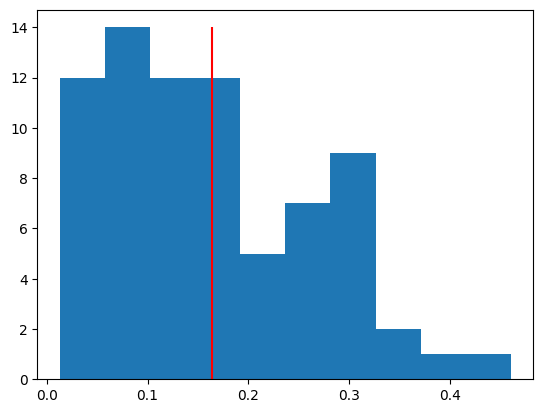

In [29]:
plt.figure()
distances = np.array([measure_distances(m_fit, k_fit, Eiso_i, Epeak_i) for Eiso_i, Epeak_i in zip(Eiso, Epeak)])
plt.hist(distances)

median = np.sum(distances)/len(distances)
plt.vlines(median, 0, 14, color='red')

# Part 2: calculating the errors on the free fitting parameters
In this next part, we are going to compute the errors on the free parameters $a$ and $b$ of the fitting model $\log_{10}(E_\text{peak}) = a\times \log_{10}(E_\text{iso}) + b$. For this we will use $\sigma^2 = \frac{\chi^2}{N-2}$, where $N=75$ is the number of data points, since the variance is defined as $\sigma^2 = \frac{\sum_i (y-y_{model})^2}{N}$ and we are using $\chi^2 = (y - y_{model})^2$, thus $\sigma^2 = \frac{\chi^2}{N}$.

In [21]:
sqchi = GoF(m_fit, k_fit, Eiso, Epeak)
print(sqchi)
sigma = sqchi/73
sigma = np.sqrt(sigma)
print(f'm = {m_fit:.4f} ± {sigma:.4f}')
print(f'k = {k_fit:.4f} ± {sigma:.4f}')

3.3164148396428517
m = 0.4545 ± 0.2131
k = -21.5152 ± 0.2131


# Appendix
---

### Appendix 1
This cell was used to manually draw a contour plot and extract the best fit values, as at the beginning the plot resulting from `plt.contourf` had some mistakes.


In [ ]:
#Since the plotting of the $lg(\chi^2)$ surface was very weird with `plt.contourf` and it didn't coincide with the best fit parameters, I plotted a similar version manually as well as extracted the minimum value for `G`, obtaining the same fit results despite the weird plot. Additionally, I've performed the fit at the end with `scipy.curve_fit`, obtaining the exact same results.

for i in range(len(m)):
    for j in range(len(k)):
        val = np.log10(G[i][j])
        if 0<val and val<=.6:
            plt.scatter(m[i],k[j],color='blue', s=1,marker='s')
        elif .6<val and val<=1:
            plt.scatter(m[i],k[j],color='green', s=1,marker='s')
        elif 1<val and val<=2:
            plt.scatter(m[i],k[j],color='orange', s=1,marker='s')
        else:
            plt.scatter(m[i],k[j],color='red', s=1,marker='s', alpha=0.3)
plt.scatter(m_fit, k_fit, marker='1', color='yellow')

minimum = 100
coords = [0,0]
for i in range(len(k)):
    for j in range(len(m)):
        if np.log10(G[i][j])<minimum:
            minimum = np.log10(G[i][j])
            coords = [k[i],m[j]]

print(fr'Minimum: {minimum}\t{10**minimum}')
print(f'k_fit={coords[0]}\tm_fit={coords[1]}')

### Appendix 2
Checking that my code was correct by comparing the results of my fit, with those using the `scipy.optimize.curve_fit` function.

In [ ]:
from scipy.optimize import curve_fit

def linear_model(x, k, m):
    return k + m * x

# Fit the model
popt, pcov = curve_fit(linear_model, Eiso, Epeak)
k_best, m_best = popt

# Get parameter uncertainties
param_errors = np.sqrt(np.diag(pcov))
print(f"Best fit: k = {k_best:.3f} ± {param_errors[0]:.3f}")
print(f"Best fit: m = {m_best:.3f} ± {param_errors[1]:.3f}")

correlation_matrix = pcov / np.outer(param_errors, param_errors)
print("Correlation matrix:")
print(correlation_matrix)